# Домашнее задание № 2 - 3


Выполнила команда "Ave Data" в рамках MTS.Teta SummerSchool


# Домашнее задание № 2

## 1. Выбор проекта 
Задачи кредитного скоринга широко используются в современных банковских процессах, позволяя автоматизировать процесс рассмотрения заявки на выдачу займа для физических или юридических лиц.


Решение задачи кредитного скоринга позволяет банкам уменьшить количество операторов, необходимых для рассмотрения заявки, а также увеличить выручку путем выдачи кредитов более надежным лицам и уменьшения вероятности невозврата кредита.


Оптимизируется процесс одобрения кредита. В банке уже может существовать своя модель или скрипт, на основе которого выносится одобрение или отклонение кредита, в таком случае наш алгоритм его заменит, в конечном итоге для дополнительной подстраховки вердикт алгоритма должен быть дополнительно одобрен работником банка.


## 2. Бизнес и математическая постановки задачи

Бизнес постановка задачи: увеличить выручку банка путем одобрения кредитов, которые будут возвращены, и отклонения тех заявок, которые возвращены не будут. 


Математическая постановка задачи: построить модель машинного обучения, предсказывающую вероятность возврата кредита для конкретного клиента.


Задача считается успешно выполненной, если удается статистически значимо уменьшить процент и суммарную стоимость невозвращенных кредитов, бонусом будет также увеличения процента и суммарной стоимости возвращаемых кредитов.
В качестве модели используется вероятностная модель классификации.


Алгоритм должен быть простым и интерпретируемым, чтобы эксперт мог понять принцип работы.
В задаче имеется дисбаланс классов, так как количество невозвращенных кредитов обычно сильно меньше возвращенных. В качестве метрики качества используется используется roc auc для борьбы с неравновесными классами. 


Модель должна ранжировать клиентов по вероятности возврата кредита. С помощью исторических данных выбирается порог отсечения (такая вероятность возврата кредита, выше которой считается, что клиент вернет кредит, а ниже - нет). 
Ошибки 1 и 2 рода не равноценны: выдача кредита с последующим невозвратом стоит для банка дороже, чем невыдача кредита, который будет возвращен.


## 3.  Выбор набора данных

Для выбора полхоядщего для данной задачи набора данных мы использовали ресурс **kagle.com**.

В итоге выбор был выбран [этот набор данных.](https://www.kaggle.com/atulmittal199174/credit-risk-analysis-for-extending-bank-loans)

## 4. Валидация данных и оценка результата

Для начала импортируем часть нужных нам библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale = 1.5)
import pandas_profiling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve

import xgboost
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

Загрузим табличку и посмотрим на нее используя рассмотренный на лекциях **pandas_profiling**

In [3]:
df = pd.read_csv('Credit Risk Analysis for extending Bank Loans.csv')

In [153]:
df

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0      41   3      17       12     176      9.3  11.359392  5.008608      1.0
1      27   1      10        6      31     17.3   1.362202  4.000798      0.0
2      40   1      15       14      55      5.5   0.856075  2.168925      0.0
3      41   1      15       14     120      2.9   2.658720  0.821280      0.0
4      24   2       2        0      28     17.3   1.787436  3.056564      1.0
...   ...  ..     ...      ...     ...      ...        ...       ...      ...
1145   34   1      12       15      32      2.7   0.239328  0.624672      NaN
1146   32   2      12       11     116      5.7   4.026708  2.585292      NaN
1147   48   1      13       11      38     10.8   0.722304  3.381696      NaN
1148   35   2       1       11      24      7.8   0.417456  1.454544      NaN
1149   37   1      20       13      41     12.9   0.899130  4.389870      NaN

[1150 rows x 9 columns]

In [4]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Анализ отчета позволяет нам заключить о том, что рассматриваемый набор данных оказался довольно неплохого качества. У него имеются ряд недостатков, таких как 4% пропущенных значений и довольно сильный дисбаланс классов. Но в остальном это все хорошо, и на таких данных вполне возможно построить алгоритм для кредитного скоринга. Так как пропусков не особо много то легче всего будет их отбросить, сделаем это и начнем построение **baseline** модели.

In [155]:
df = df.dropna()

Для дальнейшего построения модели необходимо сначала предобработать наши колонки, все числовые колонки нормализуем с помощью **StandardScaler**. Так же разделим наш набор данных на тренировочный и тестовый.

In [156]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['default'], axis = 1), df['default'], test_size= 0.2, stratify = df['default'], random_state=82)

In [157]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Для построения **baseline** модели был выбран самый распотраненный для такой задачи алгоритм логистической регрессии. В пакете **sklearn** есть реализация данной модели так же с использованием кросс валидации на **k-folds**. Обозначим разбиение на 3 фолда и зафиксируем **random_state** для воспроизводимости результатов.

In [158]:
logistic = LogisticRegressionCV(cv = 5, random_state=15)
logistic.fit(x_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=15, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Так как целевая метрика у нас была **ROC AUC** напишем функцию для построения графика и отображения значения. 

In [159]:
def plot_roc_curve(prob_prediction, actual):
    
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

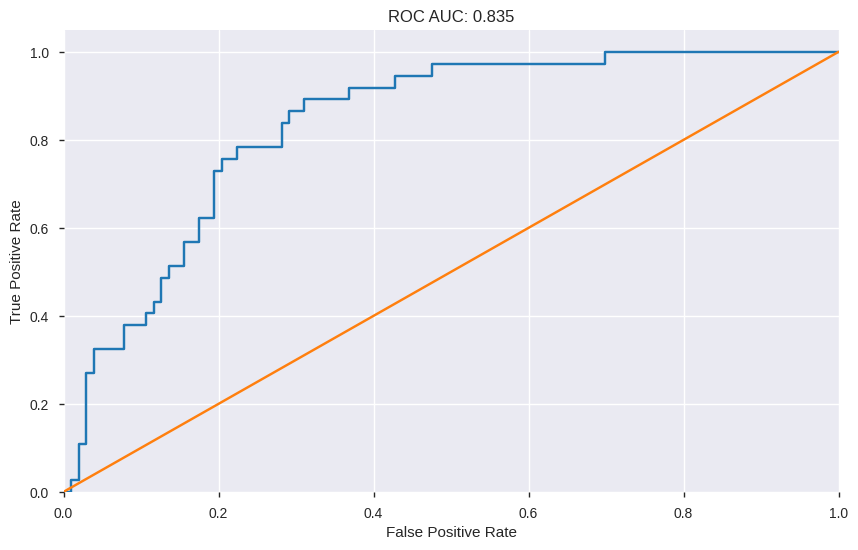

In [160]:
plot_roc_curve(logistic.predict_proba(x_test_scaled)[:,1], y_test)

Анализируя полученный результат можно сказать, что в целом наш алгоритм справился с поставленной задачей, он имеет
довольно неплохие для **baseline** модели показатели **ROC AUC** больше **0.85**. Планы на дальнейшее развитие модели, реализовать кодировку категориальных столбцов и использовать различные методики по **oversampling** и **undersampling** для балансировки классовых переменных и в следствии чего увеличение нашей **ROC AUC** метрики.

## 5. Оценка экономического эффекта

Для оценки экономического эффекта нашей модели необходимо будет учесть следующие факторы:
- насколько изменится сумма выданных кредитов
- насколько изменится сумма невозвращенных кредитов


Экономический эффект нашей модели можно рассчитать по следующей формуле: 


$$P_1 - P_2$$

где $P_1$ – выручка по кредитам до внедрения модели, $P_2$ – выручка после внедрения модели, выручку будем считать следующим образом:

$$P_2 = m\cdot TN \cdot s  - (1-RR)\cdot FN\cdot s$$

где **m(margin)** = маржа по "хорошим" кредитам, с учетом OPEX-расходов
**RR (recovery rate)** - коэффициент восстановления "плохих" кредитов (какая часть просроченных кредитов взыскана с должников)
**TN** - истинно отрицательные кредиты ("хорошие кредиты")
**s** - средний чек по выданным кредитам
**FN** - ложно отрицательные кредиты (выданные "плохие" кредиты)
Предположим, что **m**, **RR** и **s** - константы и мы на них не влияем
Наша модель может только увеличить показатель **TN** или уменьшить **FN** (увеличить **TP**), при этом приоритетно уменьшение **FN**.


# Домашнее задание № 3

## 1. Улучшение качества модели

Добавим несколько новых признаков:
* суммарный долг = долг по кредиту + другие долги
* остаток = доход - сумма платежа по долгам


In [161]:
for df in x_train, x_test:
    df['alldebt'] = df['creddebt']+df['othdebt']
    df['balance'] = df['income']-df['debtinc']

Категориальную переменную Образование(**'ed'**) закодируем с помощью **One Hot Encoder**.

In [162]:
cat_cols = ['ed']

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(x_train[cat_cols])

x_train_ohe = pd.DataFrame(enc.transform(x_train[cat_cols]), columns= enc.get_feature_names(cat_cols)) 
x_test_ohe = pd.DataFrame(enc.transform(x_test[cat_cols]), columns= enc.get_feature_names(cat_cols))

x_train = pd.concat([x_train.reset_index(drop=True), x_train_ohe],sort = False, axis=1).drop(['ed'], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), x_test_ohe],sort = False, axis=1).drop(['ed'], axis=1)

Для балансировки классов используем smote oversampling.

In [163]:
oversample = SMOTE(random_state=9)
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns=x_test.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [164]:
model =  XGBClassifier(random_state=5)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

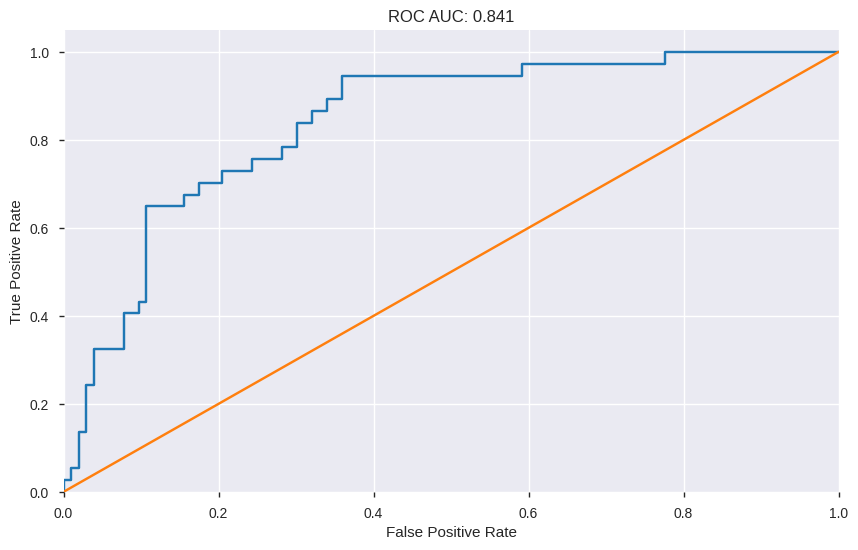

In [165]:
plot_roc_curve(model.predict_proba(x_test)[:,1], y_test)

Сам по себе градиентный бустин дает качество хуже, чем бейзлайн.

Подбор гиперпараметров

In [172]:
params = {
        'booster':['gbtree', 'gblinear', 'dart'],
        'gamma':[0,1,3],
        'num_feature' :[5,10,14],
        'min_child_weight': [1, 2],
        'colsample_bytree': [1, 2],
        'max_depth': [ 2,3,4],
        'n_estimators': [ 80, 100, 120 ],
        'learning_rate': [ 0.01, 0.1, 0.2]
        }

In [173]:
clf = GridSearchCV(model, params, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=3, refit=True)

In [174]:
clf.fit(x_train, y_train)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 6648 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9528 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 10322 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 10930 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 11602 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 14577 out of 14580 | elapsed:  9.4min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 14580 out of 14580 | elapsed:  9.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=5, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'colsample_bytree': [1, 2], 'gamma': [0, 1, 3],
                         'learning_rate': [0.01, 0.1, 0.2],
          

In [175]:
best_boosting = clf.best_estimator_
best_boosting

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, num_feature=5, objective='binary:logistic',
              random_state=5, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

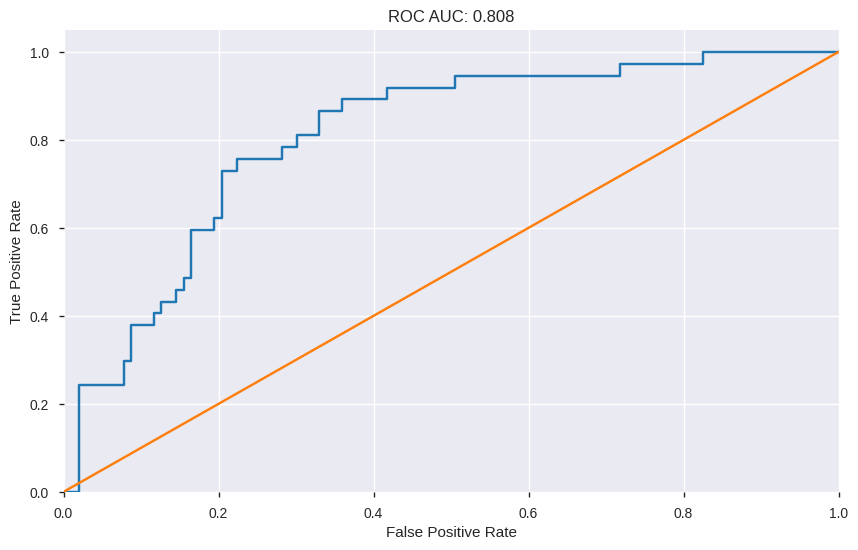

In [176]:
plot_roc_curve(best_boosting.predict_proba(x_test)[:,1], y_test)

Подбор гиперпараметров не дает прироста в качестве.

Roc auc бейзлайн модели: 0.835;
В более продвинутой модели удалось повысить roc auc до 0.841, то есть на 0.6 %.

Учитывая затраченное время на усовершенствование модели, прирост считаю не существенным.

## 2. Валидация

Исследуем стабильность модели по фолдам.

Для разбивки используем стратифицированный k-fold.

In [178]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
lst_auc_stratified = []
  
for train_index, test_index in skf.split(x_train, y_train):
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    model.fit(x_train_fold, y_train_fold)
    preds = model.predict_proba(x_test)[:,1]
    lst_auc_stratified.append(roc_auc_score(y_test, preds))
  
print('Roc auc по 5 фолдам:', lst_auc_stratified)
print('\nМаксимум:',
      max(lst_auc_stratified))
print('\nМинимум:',
      min(lst_auc_stratified))
print('\nСреднее:',
      np.mean(lst_auc_stratified))
print('\nСтандартное отклонение:', np.std(lst_auc_stratified))

Roc auc по 5 фолдам: [0.8370506428758856, 0.8433482025715036, 0.8396746260823931, 0.8171083705064288, 0.8525321437942798]

Максимум: 0.8525321437942798

Минимум: 0.8171083705064288

Среднее: 0.8379427971660982

Стандартное отклонение: 0.011661354531477213


Видно, что модель работает стабильно на всех фолдах, стандартное отклонение = 0,012.

Исследуем важность признаков.

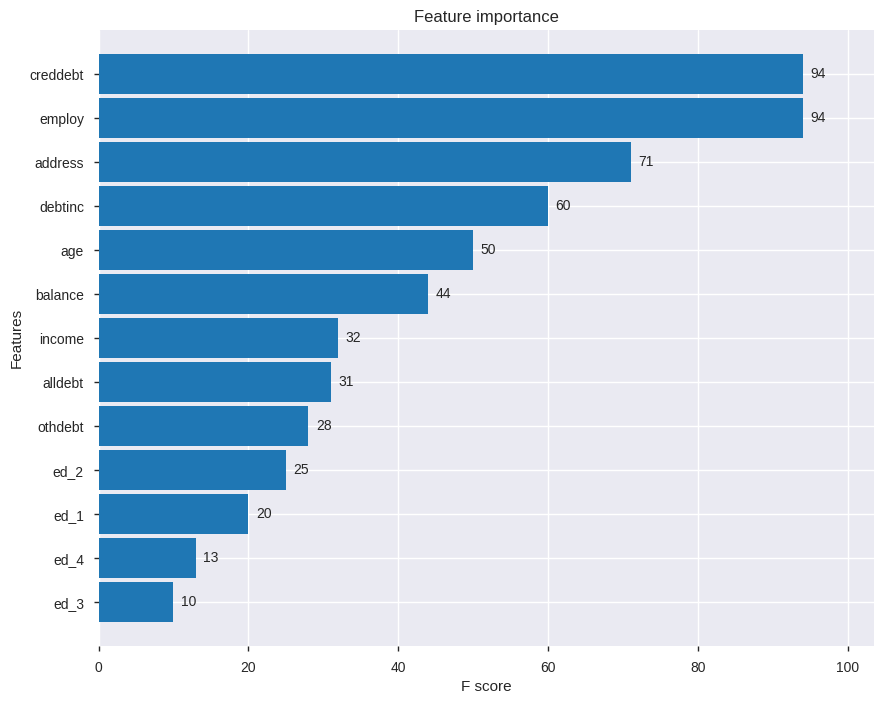

In [179]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgboost.plot_importance(model, height=0.9, ax=ax)
None

Самыми важными признаками являются трудоустройство человека и сумма долга.